# Local approximation of a bivariate quadratic expression using linear regression

Given two features, extract y (the label), perform linear regression:
- analiticaly
- analiticaly using some powers of the features
- using some off the shelve methods of Numpy
- with gradient descent (GD)
- with stochastic gradient descent (SGD)
- SGD with powers of the features

In [1]:
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
from sklearn import metrics
import scipy as sy
import pandas

In 2D, it would require many points to uniformly cover the x plan

It is then prefer to draw x points from a 2D uniform distribution

Ploting y as function of $x_0, x_1$ is then more challenging as $x_0$ and $x_1$ are not continuous monotonic vectors

$f(x) = (x_0−0.2)^4 + (x_0−0.1)^3 + 0.1 x_1^2 + 0.35 = x_0^4 + 0.2 x_0^3 − 0.06 x_0^2 − 0.002 x_0 + 0.1 x_1^2 + 0.3506$

In [2]:
# f(x) as a bivariate polynom
fPoly = np.array([[-0.002, 0], [-0.06, 0.1], [0.2, 0], [1, 0]])
# Generator
def generateBatch(N):
    #
    xMin = np.array([0, -0.5])
    xMax = np.array([0.5, 0.5])
   #
    b = 0.35
    std = 0.01
    #
    x = random.uniform(xMin, xMax, (N, 2))
    yClean = (x[:,0]-0.2)**4 + (x[:,0]-0.1)**3 + 0.1*x[:,1]**2 + b
    y =  yClean + random.normal(0, std, N) 
    return (x, y, yClean)

In [3]:
N = 100000
xTrain, yTrain, yTrainClean = generateBatch(N);

print('x', xTrain.shape, ', yClean', yTrainClean.shape, ', y', yTrain.shape);
xTest, yTest, yTestClean = generateBatch(N);

x (100000, 2) , yClean (100000,) , y (100000,)


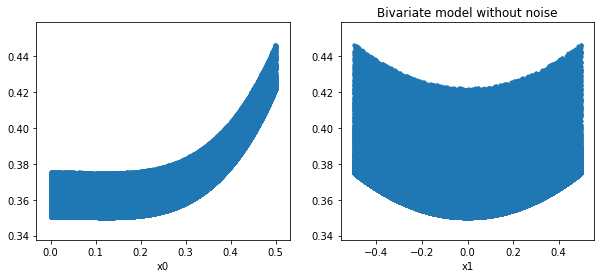

In [4]:
fig = plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(xTrain[:,0], yTrainClean, marker='.');
plt.xlabel('x0')
plt.subplot(1,2,2)
plt.scatter(xTrain[:,1], yTrainClean, marker='.');
plt.xlabel('x1')
plt.title('Bivariate model without noise');

It looks like a tobogan from the side (x0) and from the front (x1)

## Analiticaly / Closed form

Remove biases

In [5]:
xUnB = xTrain - np.mean(xTrain, axis=0)
yUnB = yTrain - np.mean(yTrain)

## Maison

In [6]:
xTxInv = np.linalg.inv(np.matmul(xUnB.T,xUnB))
w = np.matmul(xTxInv,np.matmul(xUnB.T, yUnB))
w

array([ 0.11266809, -0.00012452])

In [7]:
bEst = np.mean(yTrain - np.matmul(xTrain, w))
bEst

0.34393354556850397

In [8]:
yEst1 = np.matmul(xTest, w) + bEst

Linear regression MSE = 2.589e-04


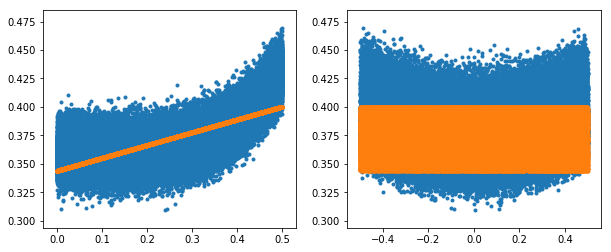

In [9]:
fig = plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(xTest[:,0], yTest, marker='.');
plt.scatter(xTest[:,0], yEst1, marker='.');
plt.subplot(1,2,2)
plt.scatter(xTest[:,1], yTest, marker='.');
plt.scatter(xTest[:,1], yEst1, marker='.');
# Mean square error 'a la mano'
mse1 = np.dot(yTest-yEst1, yTest-yEst1) / N
print('Linear regression MSE = {:.3e}'.format(mse1));

The tobogan has been approximated by a plan

## Home made with powers
Adding some flexibility to the model using powers of x

In [10]:
xTrain2 = np.concatenate((xTrain, xTrain**2, xTrain**3, xTrain**4), axis=1)
xTrain2.shape

(100000, 8)

In [11]:
x2UnB = xTrain2 - np.mean(xTrain2, axis=0)

In [12]:
x2Tx2Inv = np.linalg.inv(np.matmul(x2UnB.T,x2UnB))
w2 = np.matmul(x2Tx2Inv,np.matmul(x2UnB.T, yUnB))
w2

array([ -3.22717221e-03,  -2.17868547e-04,  -5.92601531e-02,
         9.94729030e-02,   2.08441701e-01,   1.16680159e-03,
         9.89237592e-01,   2.21004017e-04])

In [13]:
xTest2 = np.concatenate((xTest, xTest**2, xTest**3, xTest**4), axis=1)
yEst2 = np.matmul(xTest2, w2) + bEst

Linear regression with powers, MSE = 1.471e-04, MSE to clean test data = 4.657e-05


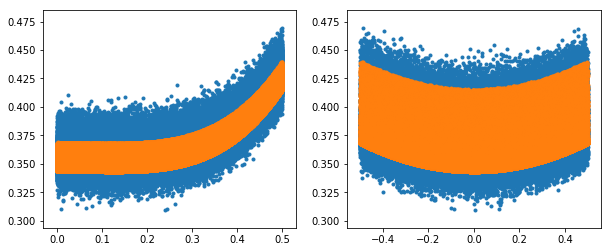

In [14]:
fig = plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(xTest2[:,0], yTest, marker='.');
plt.scatter(xTest2[:,0], yEst2, marker='.');
plt.subplot(1,2,2)
plt.scatter(xTest2[:,1], yTest, marker='.');
plt.scatter(xTest2[:,1], yEst2, marker='.');
mse2 = np.dot(yTest-yEst2, yTest-yEst2) / N
mse2Clean = np.dot(yTestClean-yEst2, yTestClean-yEst2) / N
print('Linear regression with powers, MSE = {:.3e}, MSE to clean test data = {:.3e}'.format(mse2, mse2Clean));

The polynomial of y has been well approximated.

The MSE on the noisy sample should not be lower than the MSE of the noise which is $(10^{-2})^2=10^{-4}$

## NumPy least square

In [15]:
fit4, residues, rank, s = np.linalg.lstsq(xUnB, yUnB)
fit4

array([ 0.11266809, -0.00012452])

In [16]:
yEst4 = np.matmul( xTest, fit4) + bEst

Numpy least square, MSE = 2.589e-04


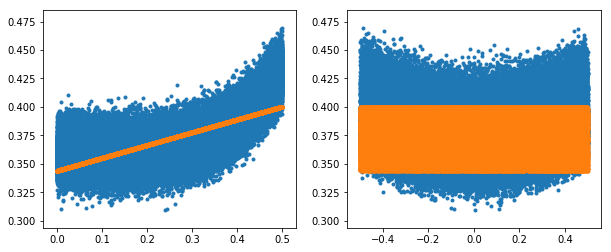

In [17]:
fig = plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(xTest[:,0], yTest, marker='.');
plt.scatter(xTest[:,0], yEst4, marker='.');
plt.subplot(1,2,2)
plt.scatter(xTest[:,1], yTest, marker='.');
plt.scatter(xTest[:,1], yEst4, marker='.');
mse4 = metrics.mean_squared_error(yTest, yEst4)
print('Numpy least square, MSE = {:.3e}'.format(mse4) );

# Gradient descent

Attempt to find a value of w such that the gradient is null (indication of minima, or saddle point)

Loop on the training data until the gradient is below a threshold

In [18]:
w6 = np.array([5, 5])
threshold = 1e-6
learningRate = 0.0001 # Quick
gradient = np.matmul(xUnB.T, np.matmul(xUnB,w6) - yUnB)
gradientNorm = np.sum(gradient**2) # bivariate
print('w start =', w6, ', Gradient norm =', gradientNorm)
w6Learn = [np.concatenate((w6, [gradientNorm]))]
while gradientNorm > threshold:
    w6 = w6 - learningRate * gradient
    gradient = np.matmul(xUnB.T, np.matmul(xUnB,w6) - yUnB)
    gradientNorm = np.sum(gradient**2) # bivariate
    # print('w =', w6, ', Gradient norm =', gradientNorm)
    w6Learn.append(np.concatenate((w6, [gradientNorm])))
print('w end =', w6, ', Gradient norm =', gradientNorm, ', num iteration =', len(w6Learn))
df6 = pandas.DataFrame(w6Learn, columns = ('w0', 'w1', 'Gradient norm'))

w start = [5 5] , Gradient norm = 1815719230.92
w end = [ 0.1126685  -0.00012452] , Gradient norm = 7.0809472291e-07 , num iteration = 71


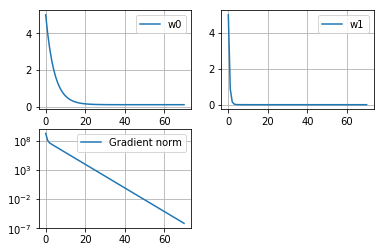

In [19]:
plt.subplot(2,2,1)
plt.plot(df6['w0'])
plt.grid()
plt.legend();
plt.subplot(2,2,2)
plt.plot(df6['w1'])
plt.grid()
plt.legend();
plt.subplot(2,2,3)
plt.semilogy(df6['Gradient norm'])
plt.grid()
plt.legend();

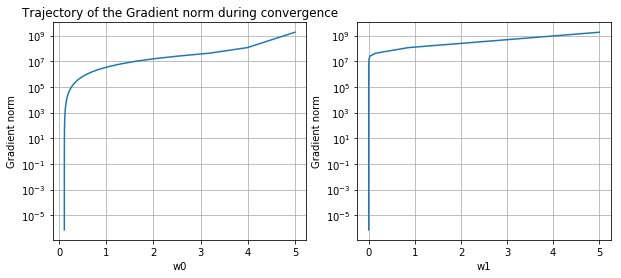

In [20]:
fig = plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.semilogy(df6['w0'], df6['Gradient norm'])
plt.xlabel('w0')
plt.ylabel('Gradient norm')
plt.grid();
plt.title('Trajectory of the Gradient norm during convergence')
plt.subplot(1,2,2)
plt.semilogy(df6['w1'], df6['Gradient norm'])
plt.xlabel('w1')
plt.ylabel('Gradient norm')
plt.grid();

In [21]:
yEst6 = np.matmul(xTest, w6) + bEst

Gradient descent MSE = 2.589e-04


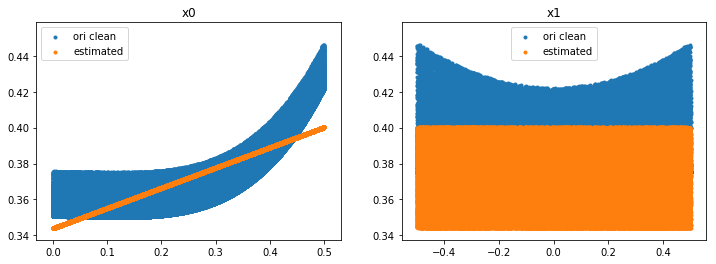

In [22]:
fig = plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.scatter(xTest[:,0], yTestClean, marker='.')
plt.scatter(xTest[:,0], yEst6, marker='.')
plt.title('x0')
plt.legend(('ori clean', 'estimated'))
plt.subplot(1,2,2)
plt.scatter(xTest[:,1], yTestClean, marker='.')
plt.scatter(xTest[:,1], yEst6, marker='.')
plt.title('x1')
plt.legend(('ori clean', 'estimated'))
mse6 = metrics.mean_squared_error(yTest, yEst6)
print('Gradient descent MSE = {:.3e}'.format(mse6));

## Stochastic gradient descent

Loop on new data

In [23]:
def calcGradient(x, y, w):
    _x = x - np.mean(x, axis=0)
    _y = y - np.mean(y)
    gradient = np.matmul(_x.T, np.matmul(_x, w) - _y)
    return gradient

In [24]:
Nbatch = 1000
w7 = np.array([5, 5])
threshold = 1e-6
learningRate = 0.01
# Initial batch
xBatch, yBatch, yBC = generateBatch(Nbatch)
gradient = calcGradient(xBatch, yBatch, w7)
gradientNorm = np.sum(gradient**2) 
print('w start =', w7, ', Gradient norm =', gradientNorm)
w7Learn = [np.concatenate((w7, [gradientNorm]))]
# Continue
while gradientNorm > threshold:
    w7 = w7 - learningRate * gradient
    xBatch, yBatch, yBC = generateBatch(Nbatch)
    gradient = calcGradient(xBatch, yBatch, w7)
    gradientNorm = np.sum(gradient**2)
    w7Learn.append(np.concatenate((w7, [gradientNorm])))
    learningRate = learningRate * 0.99
print('w end =', w7, ', Gradient norm =', gradientNorm, ', num iteration =', len(w7Learn))
df7 = pandas.DataFrame(w7Learn, columns = ('w0', 'w1', 'Gradient norm'))

w start = [5 5] , Gradient norm = 179473.88829
w end = [ 0.11285239 -0.00012407] , Gradient norm = 9.75106361465e-07 , num iteration = 15501


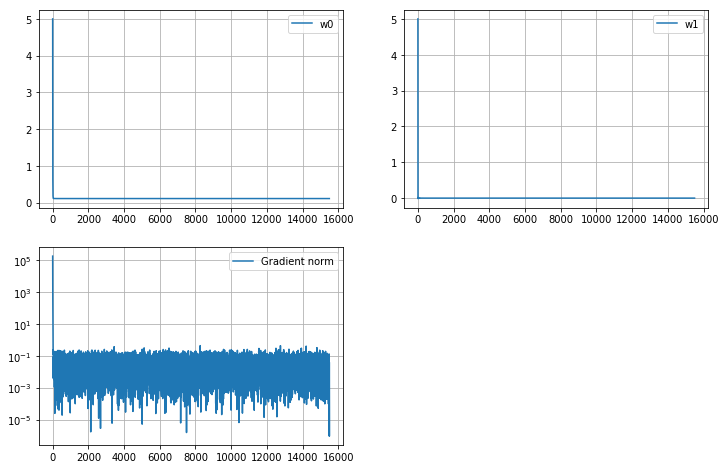

In [25]:
fig = plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.plot(df7['w0'])
plt.grid()
plt.legend();
plt.subplot(2,2,2)
plt.plot(df7['w1'])
plt.grid()
plt.legend();
plt.subplot(2,2,3)
plt.semilogy(df7['Gradient norm'])
plt.grid()
plt.legend();

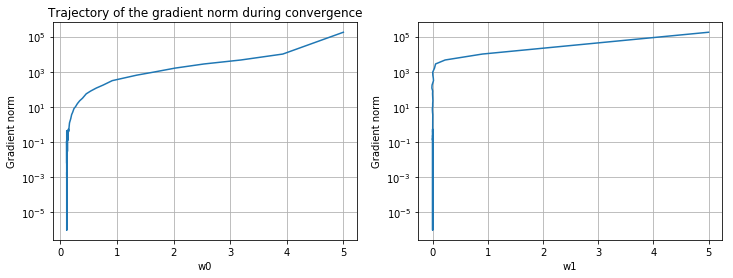

In [26]:
fig = plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.semilogy(df7['w0'], df7['Gradient norm'])
plt.xlabel('w0')
plt.ylabel('Gradient norm')
plt.grid();
plt.title('Trajectory of the gradient norm during convergence')
plt.subplot(1,2,2)
plt.semilogy(df7['w1'], df7['Gradient norm'])
plt.xlabel('w1')
plt.ylabel('Gradient norm')
plt.grid();

In [27]:
yEst7 = np.matmul(xTest, w7) + bEst

Stochastic gradient descent MSE = 2.589e-04


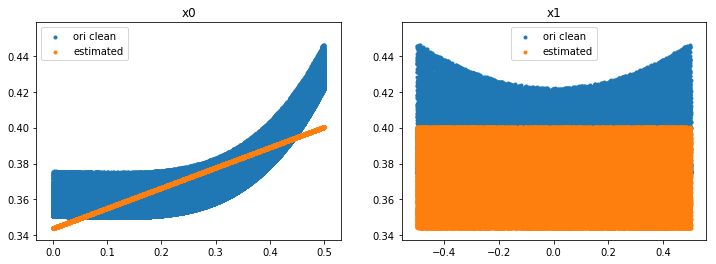

In [28]:
fig = plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.scatter(xTest[:,0], yTestClean, marker='.')
plt.scatter(xTest[:,0], yEst7, marker='.')
plt.title('x0')
plt.legend(('ori clean', 'estimated'))
plt.subplot(1,2,2)
plt.scatter(xTest[:,1], yTestClean, marker='.')
plt.scatter(xTest[:,1], yEst7, marker='.')
plt.title('x1')
plt.legend(('ori clean', 'estimated'))
mse7 = metrics.mean_squared_error(yTest, yEst7)
print('Stochastic gradient descent MSE = {:.3e}'.format(mse7));

## SGD with powers

Adding powers of x to the stochastic gradient descent

In [29]:
# Batch size
Nbatch = 1000
# Initial coefficient (fixed and tuned manually for this trial)
w8 = np.ones(8)* 1.5 
# Gradient descent end threshold (on the gradient)
threshold = 5e-4
# Initial learning rate
learningRate = 0.01
# Initial batch
xBatch, yBatch, yBC = generateBatch(Nbatch)
xBatch2 = np.concatenate((xBatch, xBatch**2, xBatch**3, xBatch**4), axis = 1)
gradient = calcGradient(xBatch2, yBatch, w8)
gradientNorm = np.sum(gradient**2) 
print('w start =', w8, ', Gradient norm = {:.3e}'.format(gradientNorm))
# Save the 
w8Learn = [np.concatenate((w8, [gradientNorm]))]
# Continue
while gradientNorm > threshold:
    w8 = w8 - learningRate * gradient
    xBatch, yBatch, yBC = generateBatch(Nbatch)
    xBatch2 = np.concatenate((xBatch, xBatch**2, xBatch**3, xBatch**4), axis = 1)
    gradient = calcGradient(xBatch2, yBatch, w8)
    gradientNorm = np.sum(gradient**2)
    w8Learn.append(np.concatenate((w8, [gradientNorm])))
    learningRate = learningRate * 0.999
print('w end =', w8, ', Gradient norm = {:.3e}'.format(gradientNorm), ', num iteration =', len(w8Learn))
df8 = pandas.DataFrame(w8Learn, columns = ('w0_1', 'w1_1', 'w0_2', 'w1_2', 'w0_3', 'w1_3', 'w0_4', 'w1_4', 'Gradient norm'))

w start = [ 1.5  1.5  1.5  1.5  1.5  1.5  1.5  1.5] , Gradient norm = 2.712e+04
w end = [ 0.01935287 -0.00568483 -0.19216103 -0.09838135  0.43247413  0.03767737
  0.9234045   0.92204256] , Gradient norm = 3.890e-04 , num iteration = 38237


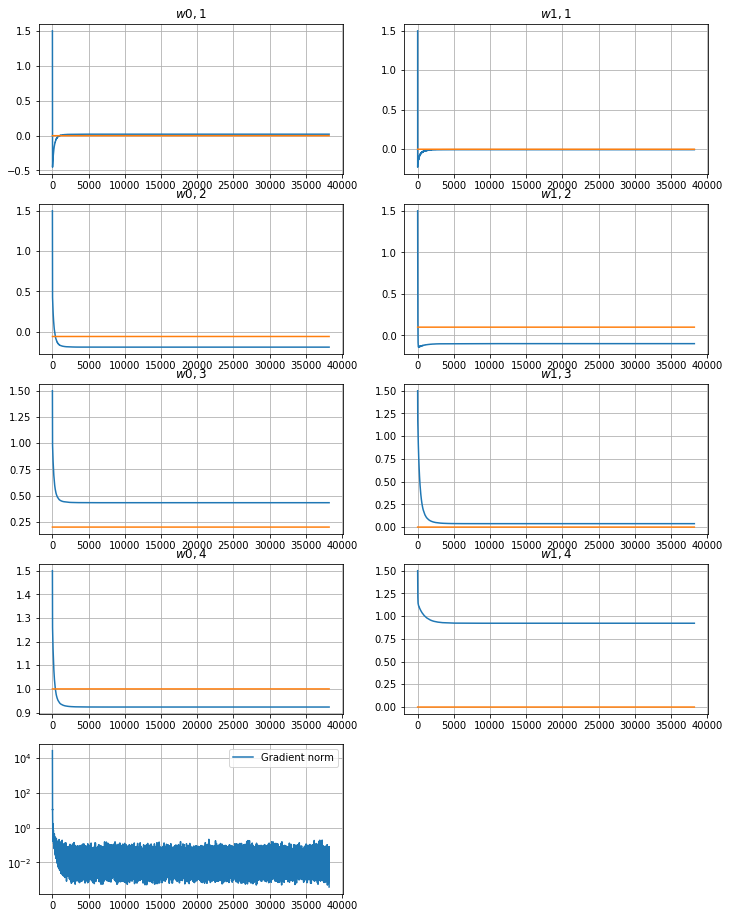

In [30]:
# Plot Helper to show target reference value
def plotToRef(label, subNum, subRow, subCol, ref, values):
    nIter = len(values)
    r = range(nIter)
    plt.subplot(subNum, subRow, subCol)
    plt.title(label)
    plt.plot(r, values, r, np.ones((nIter))*ref)
    plt.grid();
#
fig = plt.figure(figsize=(12,16))
plotToRef('$w0,1$', 5,2,1, fPoly[0,0], df8['w0_1'])
plotToRef('$w1,1$', 5,2,2, fPoly[0,1], df8['w1_1'])
plotToRef('$w0,2$', 5,2,3, fPoly[1,0], df8['w0_2'])
plotToRef('$w1,2$', 5,2,4, fPoly[1,1], df8['w1_2'])
plotToRef('$w0,3$', 5,2,5, fPoly[2,0], df8['w0_3'])
plotToRef('$w1,3$', 5,2,6, fPoly[2,1], df8['w1_3'])
plotToRef('$w0,4$', 5,2,7, fPoly[3,0], df8['w0_4'])
plotToRef('$w1,4$', 5,2,8, fPoly[3,1], df8['w1_4'])
plt.subplot(5,2,9)
plt.semilogy(df8['Gradient norm'])
plt.grid()
plt.legend();

Convergence is not correct on $w_{1}$ that should only feature a small coefficient on the 2nd order term and no coefficient on the fourth order $w_{1,4}$

In [31]:
yEst8 = np.matmul(xTest2, w8) + bEst

Stochastic gradient descent MSE = 2.427e-04


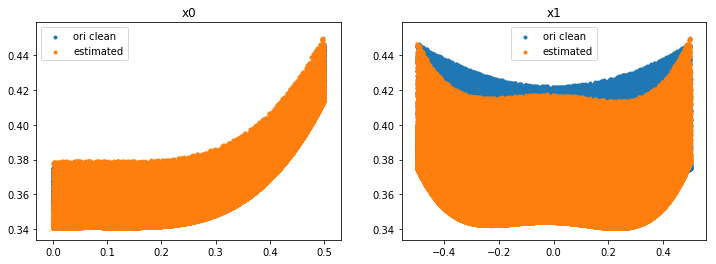

In [32]:
fig = plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.scatter(xTest[:,0], yTestClean, marker='.')
plt.scatter(xTest[:,0], yEst8, marker='.')
plt.title('x0')
plt.legend(('ori clean', 'estimated'))
plt.subplot(1,2,2)
plt.scatter(xTest[:,1], yTestClean, marker='.')
plt.scatter(xTest[:,1], yEst8, marker='.')
plt.title('x1')
plt.legend(('ori clean', 'estimated'))
mse8 = metrics.mean_squared_error(yTest, yEst8)
print('Stochastic gradient descent MSE = {:.3e}'.format(mse8));

The polynomial terms are not improving the MSE and are making the descent harder to tune